In [105]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import matplotlib.pyplot as plt
#from evaluation.analysis import get_gen_chl, get_var, rmse_chl, nrmse_chl, print_map
from preprocess_flat import mon_cos, mon_sin
from evaluation.analysis import get_var
from mpl_toolkits.basemap import Basemap,cm 
import glob
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec
import os
from lap_diffusionMask import lap_diffusionMask
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

### Constants

In [2]:
nlat = 178
nlon = 358
nt = 216
ny = 2016-1998
ndy = 12
nmon = 12
nvar = 12
npara = 7
startY = 1998
endY = 2016
fill_value = -9999.0
path = 'data/interpolated/'

In [116]:
def print_map_data(var,sub=111,vmin=None,vmax=None,save=False,lon_lat_path="./data/INPUT_AI/1999/10/chl_199910.nc"):

    plt.subplot(sub)

    map = Basemap(projection='merc',llcrnrlon=20,urcrnrlon=380,llcrnrlat=-60,urcrnrlat=60,resolution="l")

    path = lon_lat_path
    ncfile = nc.Dataset(path)
    lons = ncfile.variables['lon'][:].data
    lats = ncfile.variables['lat'][:].data
    xx, yy = np.meshgrid(lons, lats)

    if vmin == None:
        vmin = np.min(var.squeeze())
    if vmax == None:
        vmax = np.max(var.squeeze())
        
    cmap = plt.get_cmap("viridis")

    colormesh = map.pcolormesh(xx, yy, var,latlon=True, vmin = vmin, vmax =vmax, cmap=cm.sstanom)
    contour = map.contour(xx, yy,(var),  np.arange(-1, 1, 0.3 ),latlon=True, linestyles = 'solid')
    cb = map.colorbar(colormesh, location='right', label="")
    map.drawmeridians(np.arange(1.5,358.5,100.0),labels=[0,1,1,0]) #longitudes
    map.drawparallels(np.arange(-89.0,88.0,30.0),labels=[1,0,0,1]) #latitudes
    #cb.add_lines(contour)
    #cb.set_ticks([-10, -5, 5, 30])
    if save == True:
        plt.savefig("./figs/"+label_name+'.png')
        

### Loading all variables

In [29]:
chl = get_var("chl")
sla = get_var("sla")
sst = get_var("sst")
sw = get_var("sw")
uera = get_var("uera")
vera = get_var("vera")
u = get_var("u")
v = get_var("v")              

### Interpolating all missing Data with the diffusion equation

##### diffusion parameters

In [5]:
lam = 0.001
ite = 100
lamData = 0.0001

In [6]:
def diffuse_map(data,lam,ite,lamData):
    nt, nlat, nlon = data.shape
    diffused_map = np.empty([nt,nlat,nlon])
    for i in range(nt):
        real_value = data[i,...]
        real_value = np.reshape(real_value,[nlat*nlon])
        real_value = ma.masked_array(real_value, np.isnan(real_value))
        new_mask = ~(real_value.mask)
        new_value = np.nan_to_num(real_value.data)
        
        for it in range(0:10):
            #RESHAPING TO IMAGE SIZE AND MEASURING THE NEW DIFFUSED MAP
            new_value = np.reshape(new_value,[nlat,nlon])
            
            
            I     = real_value
            lapI  = np.zeros((I.shape[0],I.shape[1],4))
            slapI = np.zeros((I.shape[0],I.shape[1]))
            for ii in range(0,iter):
                ## compute laplacian
                Ix           = I[1:,:]-I[0:-1,:]
                Iy           = I[:,1:]-I[:,0:-1]
                lapI[:,:,0]  = np.concatenate((-Ix[0:1,:],Ix),axis=0)
                lapI[:,:,1]  = np.concatenate((-Ix,Ix[I.shape[0]-2:,:]),axis=0)
                lapI[:,:,2]  = np.concatenate((-Iy[:,0:1],Iy),axis=1)
                lapI[:,:,3]  = np.concatenate((-Iy,Iy[:,I.shape[1]-2:]),axis=1)

                slapI = np.nansum(lapI,axis=2) / (1e-10+np.nansum(1.0-np.isnan(lapI).astype(float),axis=2))
                I     = I - lam * slapI + lamData * (Iinit - I)
                
                I = new_mask * I + (1-new_mask) * real_value
                

            diff_value = lap_diffusionMask(new_value,ite,lam,lamData)

            
            #RESHAPING THE NEW DIFFUSED MAP AND APPLYING THE MASK
            diff_value = np.reshape(diff_value,[nlat*nlon])
            new_value = np.reshape(new_value,[nlat*nlon])
            diff_value[new_mask] = new_value[new_mask]
            
            
            #updating the new map
            new_value = diff_value
            
            #GETTING THE NEW MASK
            new_value = ma.masked_array(new_value, np.isnan(new_value))
            new_mask = ~(new_value.mask)
            new_value = new_value.data
            
        new_value = np.reshape(new_value,[nlat,nlon])
        diffused_map[i,...] = new_value
        
    return diffused_map
            
            

In [101]:
data     = get_var("sst")
I        = data[10,...]
lapI     = np.zeros((I.shape[0],I.shape[1],4))
slapI    = np.zeros((I.shape[0],I.shape[1]))
new_mask = 1. - np.isnan(I).astype(float)

#I = np.log(I)

I   = I - np.nanmean( I )
I   = np.nan_to_num( I )
I0  = I
lam = 0.25
for ii in range(0,1000):
    ## compute laplacian
    Ix           = I[1:,:]-I[0:-1,:]
    Iy           = I[:,1:]-I[:,0:-1]
    lapI[:,:,0]  = np.concatenate((-Ix[0:1,:],Ix),axis=0)
    lapI[:,:,1]  = np.concatenate((-Ix,Ix[I.shape[0]-2:,:]),axis=0)
    lapI[:,:,2]  = np.concatenate((-Iy[:,0:1],Iy),axis=1)
    lapI[:,:,3]  = np.concatenate((-Iy,Iy[:,I.shape[1]-2:]),axis=1)

    slapI = np.nansum(lapI,axis=2) / (1e-10+np.nansum(1.0-np.isnan(lapI).astype(float),axis=2))
    I     = I - lam * slapI

    I = new_mask * I0 + (1-new_mask) * I


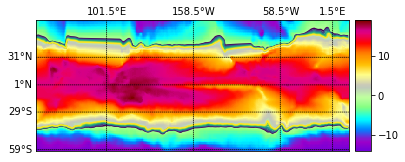

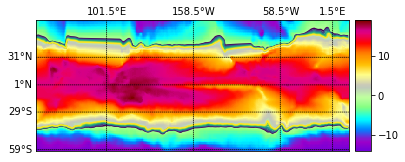

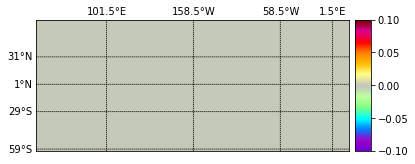

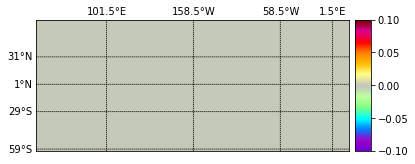

In [117]:
plt.figure()
print_map_data(I)

plt.figure()
print_map_data(I0)

plt.figure()
print_map_data(I0 -I )

plt.figure()
print_map_data(I * (1.-new_mask))


In [7]:
chl[chl>1] = np.nan
diff_chl =  diffuse_map(chl,lam,ite,lamData)
diff_sla = diffuse_map(sla,lam,ite,lamData)
diff_sst = diffuse_map(sst,lam,ite,lamData)
diff_sw = diffuse_map(sw,lam,ite,lamData)
diff_uera = diffuse_map(uera,lam,ite,lamData)
diff_vera = diffuse_map(vera,lam,ite,lamData)
diff_u = diffuse_map(u,lam,ite,lamData)
diff_v = diffuse_map(v,lam,ite,lamData)              

#### Saving interpolated Data

In [8]:
path = "data/interpolated/"
np.save(path+"chl",diff_chl)
np.save(path+"sla",diff_sla)
np.save(path+"sst",diff_sst)
np.save(path+"sw",diff_sw)
np.save(path+"uera",diff_uera)
np.save(path+"vera",diff_vera)
np.save(path+"u",diff_u)
np.save(path+"v",diff_v)

#### Creating Date data

In [12]:
years = np.empty([nt,nlat,nlon])
for t in range(ny):
    years[t*ndy:(t+ndy)*ndy ,...] = t + startY

In [13]:
months = np.empty([nt,nlat,nlon])
for t in range(nt):
    months[t,...] = t%ndy + 1

In [14]:
mon_1 = mon_sin(months)
mon_2 = mon_cos(months)

In [15]:
np.save(path+"mon_1",mon_1)
np.save(path+"mon_2",mon_2)
np.save(path+"year",years)

In [4]:
diff_chl =  np.load(path+"chl.npy")
diff_sla = np.load(path+"sla.npy")
diff_sst = np.load(path+"sst.npy")
diff_sw = np.load(path+"sw.npy")
diff_uera = np.load(path+"uera.npy")
diff_vera = np.load(path+"vera.npy")
diff_u = np.load(path+"u.npy")
diff_v = np.load(path+"v.npy")

In [16]:
x = np.stack([diff_sla, diff_sst, diff_sw, diff_uera, diff_vera, diff_u, diff_v, mon_1, mon_2, years],axis=-1)
y = (diff_chl)

In [17]:
np.save("data/interpolated/X.npy", x)
np.save("data/interpolated/Y.npy", y)

In [6]:
def print_max_min_mean(arr):
    print('mean={} , max={} , min={}'.format(np.nanmean(arr),np.nanmax(arr),np.nanmin(arr)))

array([0.6446398 , 0.61746395, 0.40783128, ..., 1.2788484 , 0.11090091,
       0.4827061 ], dtype=float32)

In [7]:
print_max_min_mean(diff_chl)

mean=0.10184566843670306 , max=0.999996542930603 , min=5.042135629419999e-243


In [61]:
for i in range(1,8):
    print("chl > ",i,"",chl[chl>i].shape[0] / chl[~np.isnan(chl)].shape[0])

chl >  1  0.045999216340420174
chl >  2  0.014842054225985727
chl >  3  0.0066514452501713825
chl >  4  0.003618801370727982
chl >  5  0.002291079433794222
chl >  6  0.0015604183179805707
chl >  7  0.0011106214580567533


In [10]:
print_max_min_mean(chl)

mean=0.2903861999511719 , max=92.91448974609375 , min=0.0010007894597947598


In [18]:
print_max_min_mean(sst)

mean=12.606260299682617 , max=35.3112907409668 , min=-1.7999995946884155


In [19]:
print_max_min_mean(sla)

mean=0.03772563114762306 , max=1.137137532234192 , min=-1.140718698501587


In [20]:
print_max_min_mean(sw)

mean=185.84751892089844 , max=533.1442260742188 , min=-0.12096401304006577


In [21]:
print_max_min_mean(uera)

mean=0.3080955445766449 , max=13.824784278869629 , min=-15.075916290283203


In [22]:
print_max_min_mean(vera)

mean=0.09505581110715866 , max=13.980010032653809 , min=-12.300956726074219


In [23]:
print_max_min_mean(v)

mean=0.004475568886846304 , max=1.6527632474899292 , min=-1.4756970405578613


In [24]:
print_max_min_mean(u)

mean=0.003977432381361723 , max=1.5854690074920654 , min=-1.43561589717865
